In [111]:
import src.models as models
import src.preprocessing as pre
import src.plots as plots
import src.metrics as metrics

In [112]:
import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [113]:
import fastf1 as ff1

# Habilitar  caché en una carpeta del proyecto
ff1.Cache.enable_cache("./cache")

1) Division de los Datos

Vamos a definir a continuacion que features del dataset podrian ser utiles para entrenar nuestro modelo. Con este analisis pretendemos hacer una primera division entre features probablemente utiles y features peligrosas que en principio descartariamos para no generar dataleakage

Empecemos por cargar la carrera de Monaco 2025 (Monaco Grand Prix)

In [114]:

year = 2025
gp_name = "Monaco"   # Monaco
session_name = "R"               # Race

session = ff1.get_session(year, gp_name, session_name)
session.load()

laps = session.laps


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.1]


req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '16', '81', '1', '44', '6', '31', '30', '23', '55', '63', '87', '43', '5', '18', '27', '22', '12', '14', '10']


Veamos como esta compuesto el dataset:

In [115]:
print("Datos disponibles por cada vuelta:\n")
# Mostrar prolijamente las columnas
for col in laps.columns: 
    print(col)
    

Datos disponibles por cada vuelta:

Time
Driver
DriverNumber
LapTime
LapNumber
Stint
PitOutTime
PitInTime
Sector1Time
Sector2Time
Sector3Time
Sector1SessionTime
Sector2SessionTime
Sector3SessionTime
SpeedI1
SpeedI2
SpeedFL
SpeedST
IsPersonalBest
Compound
TyreLife
FreshTyre
Team
LapStartTime
LapStartDate
TrackStatus
Position
Deleted
DeletedReason
FastF1Generated
IsAccurate


Viendo la lista de datos:
- Laptime es nuestro Target

Podemos descartar rapidamente para evitar dataleakeage:
- Sector1Time, Sector2Time y Sector3Time ya que no son mas que el Target descompuesto en 3 tiempos.
- IsPersonalBest tambien la podemos descartar ya que usa info de todas las vueltas del piloto y depende de saber cuales fueron las mas rapidas

Por ser tiempos absolutos de sesión (los podriamos usar más adelante como features derivados, pero no crudos):
- Time
- Sector1SessionTime, Sector2SessionTime, Sector3SessionTime
- LapStartTime, LapStartDate
- PitInTime, PitOutTime

Por depender de telemetría dentro de la vuelta y qyue no es conocida antes de correrla:
- SpeedI1, SpeedI2, SpeedFL, SpeedST (speed traps durante la vuelta).

Por ser meta-datos o cosas mas raras:
- Deleted, DeletedReason, IsAccurate (sirven para filtrar vueltas malas, no para predecir)
- TyresNotChanged, LapFlags, LapCountTime, StartLaps, Outlap, etc. (campos poco claros / sin documentación fuerte, los ignoramos para empezar)


In [116]:
# Me las guardo para despues
FEATURES_DROP_SIM = [
    "LapTime",
    "Sector1Time", "Sector2Time", "Sector3Time",
    "Sector1SessionTime", "Sector2SessionTime", "Sector3SessionTime",
    "Time", "LapStartTime", "LapStartDate",
    "PitInTime", "PitOutTime",
    "SpeedI1", "SpeedI2", "SpeedFL", "SpeedST",
    "IsPersonalBest",
    "Deleted", "DeletedReason", "IsAccurate",
    "TyresNotChanged", "LapFlags", "LapCountTime", "StartLaps", "Outlap",
]


Filtro solo por las vueltas de Colapinto

In [117]:
# 2) Filtrar las vueltas de Franco Colapinto
driver_code = "COL"

col_laps = laps[
    (laps["Driver"] == driver_code)
    & laps["LapTime"].notna()
    & (~laps.get("Deleted", False))   # si 'Deleted' existe y es True, la sacamos
]

# Ordenamos por número de vuelta por prolijidad
col_laps = col_laps.sort_values("LapNumber").reset_index(drop=True)

# 3) Vector Y: tiempos de vuelta (en segundos)
Y = col_laps["LapTime"].dt.total_seconds().to_numpy()

print(f"Nº de vueltas de Colapinto en carrera: {len(Y)}")
print("Primeros 5 tiempos (s):", Y[:5])


Nº de vueltas de Colapinto en carrera: 76
Primeros 5 tiempos (s): [ 96.577 110.894 108.913  96.476  79.999]


Ahora como primera aproximacion basica voy a usar los siguientes features para mi X:

Datos de vuelta:
- LapNumber: Índice de vuelta en carrera → captura efecto de peso de combustible que baja, evolución de pista, etc.
- Stint: Número de stint → correlaciona con cambio de compuesto / momento de la carrera.

Datos de Neumáticos:
- Compound (categórica: SOFT / MEDIUM / HARD / INTERMEDIATE / WET)
- TyreLife (float: vueltas que tiene ese neumático)
- FreshTyre (bool: si el set era nuevo al inicio del stint)


Datos de Contexto de carrera:
- TrackStatus (string con códigos de estado de pista: verde, SC, VSC, etc.)
- Position (posición en carrera al final de la vuelta; para el simulador la vamos a aproximar como posición al inicio de la siguiente vuelta).


In [118]:
FEATURES_BASIC = [
    "LapNumber",
    "Stint",
    "Compound",
    "TyreLife",
    "FreshTyre",
    "TrackStatus",
    "Position",
]

# Nos quedamos solo con las que efectivamente existen en el DF por si faltara alguna
FEATURES_BASIC = [c for c in FEATURES_BASIC if c in col_laps.columns]

X = col_laps[FEATURES_BASIC].copy()
X.head()


,LapNumber,Stint,Compound,TyreLife,FreshTyre,TrackStatus,Position
0,1.0,1.0,HARD,1.0,True,126,15.0
1,2.0,1.0,HARD,2.0,True,6,15.0
2,3.0,1.0,HARD,3.0,True,6,15.0
3,4.0,1.0,HARD,4.0,True,671,15.0
4,5.0,1.0,HARD,5.0,True,1,15.0


2) Primer Analisis Exploratorio de Datos

In [119]:
# Columna de LapTime en segundos
col_laps = col_laps.copy()
col_laps["LapTime_s"] = col_laps["LapTime"].dt.total_seconds()

# Por prolijidad, nos quedamos con un subconjunto de columnas relevantes para EDA
cols_eda = [
    "LapNumber", "LapTime", "LapTime_s",
    "Stint", "Compound", "TyreLife",
    "TrackStatus", "Position"
]
cols_eda = [c for c in cols_eda if c in col_laps.columns]

col_laps[cols_eda].head()
col_laps[["LapTime_s", "TyreLife"]].describe()


,LapTime_s,TyreLife
count,76.000000,76.000000
mean,80.144171,20.368421
std,6.532176,14.115563
min,75.298000,1.000000
25%,77.545500,9.000000
50%,78.594000,16.500000
75%,79.908000,31.250000
max,110.894000,50.000000


Veamos una evolución del tiempo de vuelta a lo largo de la carrera

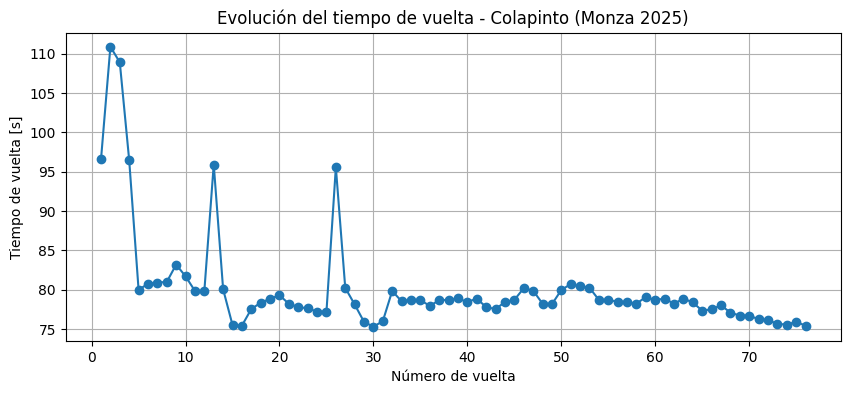

In [120]:
plt.figure(figsize=(10, 4))
plt.plot(col_laps["LapNumber"], col_laps["LapTime_s"], marker="o")
plt.xlabel("Número de vuelta")
plt.ylabel("Tiempo de vuelta [s]")
plt.title("Evolución del tiempo de vuelta - Colapinto (Monza 2025)")
plt.grid(True)
plt.show()


Histograma de tiempos de vuelta

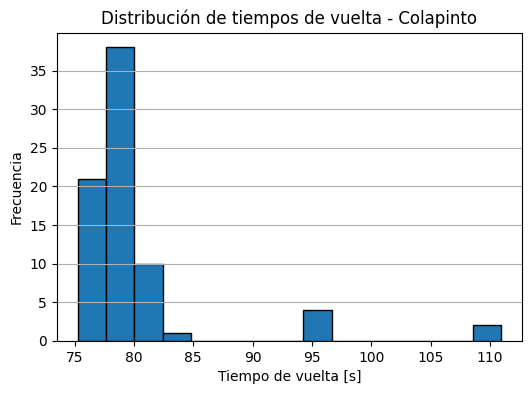

In [121]:
plt.figure(figsize=(6, 4))
plt.hist(col_laps["LapTime_s"], bins=15, edgecolor="black")
plt.xlabel("Tiempo de vuelta [s]")
plt.ylabel("Frecuencia")
plt.title("Distribución de tiempos de vuelta - Colapinto")
plt.grid(axis="y")
plt.show()


Tiempo de vuelta vs número de stint (cambio de neumáticos)

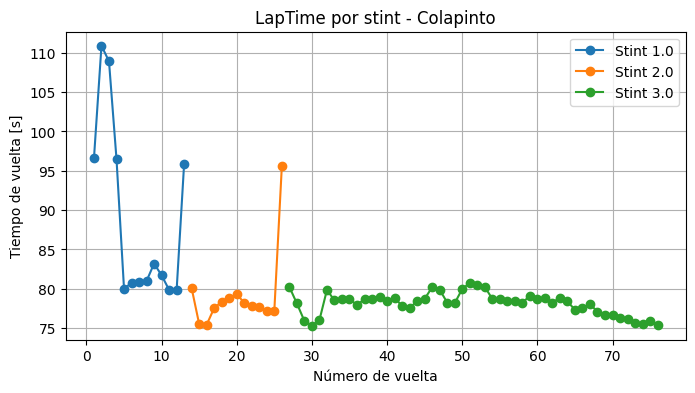

In [122]:
if "Stint" in col_laps.columns:
    plt.figure(figsize=(8, 4))
    for stint, df_stint in col_laps.groupby("Stint"):
        plt.plot(df_stint["LapNumber"], df_stint["LapTime_s"],
                 marker="o", linestyle="-", label=f"Stint {stint}")
    plt.xlabel("Número de vuelta")
    plt.ylabel("Tiempo de vuelta [s]")
    plt.title("LapTime por stint - Colapinto")
    plt.legend()
    plt.grid(True)
    plt.show()


Relación entre TyreLife y tiempo de vuelta

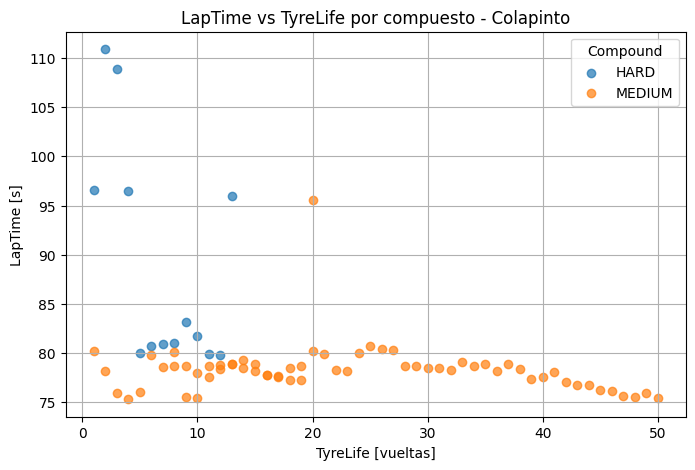

In [123]:
if "TyreLife" in col_laps.columns and "Compound" in col_laps.columns:
    plt.figure(figsize=(8, 5))

    compounds = col_laps["Compound"].dropna().unique()
    for comp in compounds:
        df_c = col_laps[col_laps["Compound"] == comp]
        plt.scatter(df_c["TyreLife"], df_c["LapTime_s"], alpha=0.7, label=comp)

    plt.xlabel("TyreLife [vueltas]")
    plt.ylabel("LapTime [s]")
    plt.title("LapTime vs TyreLife por compuesto - Colapinto")
    plt.legend(title="Compound")
    plt.grid(True)
    plt.show()

Posición en carrera vs vuelta (race trace)

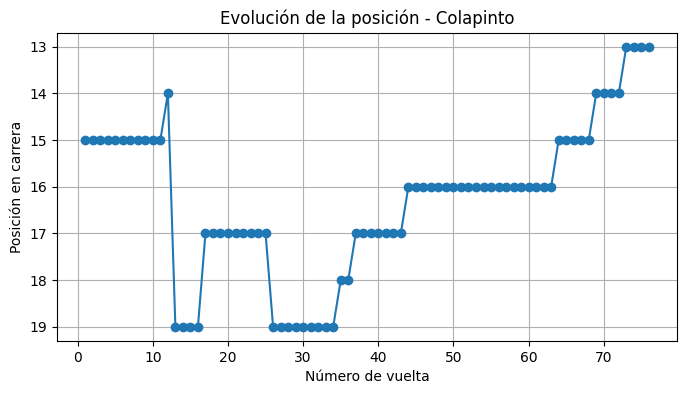

In [124]:
if "Position" in col_laps.columns:
    plt.figure(figsize=(8, 4))
    plt.plot(col_laps["LapNumber"], col_laps["Position"], marker="o")
    plt.xlabel("Número de vuelta")
    plt.ylabel("Posición en carrera")
    plt.title("Evolución de la posición - Colapinto")
    plt.gca().invert_yaxis()  # posición 1 arriba, 20 abajo
    plt.grid(True)
    plt.show()


TrackStatus vs LapNumber

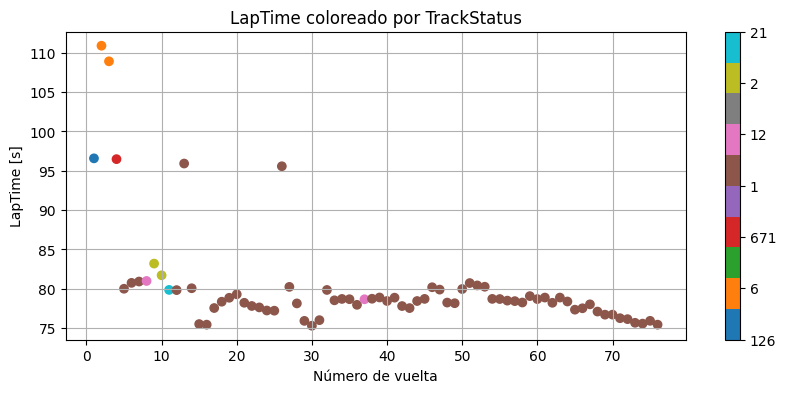

In [125]:
if "TrackStatus" in col_laps.columns:
    # Mapeamos cada TrackStatus a un número.
    status_codes = {st: i for i, st in enumerate(col_laps["TrackStatus"].astype(str).unique())} 
    col_laps["TrackStatus_code"] = col_laps["TrackStatus"].astype(str).map(status_codes)

    plt.figure(figsize=(10, 4))
    plt.scatter(col_laps["LapNumber"], col_laps["LapTime_s"],
                c=col_laps["TrackStatus_code"], cmap="tab10")
    cbar = plt.colorbar()
    cbar.set_ticks(list(status_codes.values()))
    cbar.set_ticklabels(list(status_codes.keys()))
    plt.xlabel("Número de vuelta")
    plt.ylabel("LapTime [s]")
    plt.title("LapTime coloreado por TrackStatus")
    plt.grid(True)
    plt.show()


PROXIMOS PASOS:

- Detectar outliers de LapTime (vueltas raras que quizás conviene sacar).

- Entender cómo influye el neumático y su vida en el tiempo de vuelta.

- Ver si el ritmo cambia mucho entre stints.

- Ver que paso en la carrera de Colapinto en la vida real. Por ej me acuerdo que en monza se sentia mal o algo asi. (posición, laps bajo SC, etc.).

- Tendriamos que repetir el proceso para otros circuitos a ver si notamos comportamientos similares o si detalles puntuales son solo de este circuito como la baja de tiempos post cambio de ruedas.

PARA PENSAR:

- Que otras formas de armar el set de train podemos usar? (Carrera+FP1+FP2+FP3 / Solo Carrera / Usar solo Carrera pero usar todos los Circuitos del calendario / Usar todo de todo)

- Que modelos vamos a usar?

EDA sobre las Practicas Libres 1, 2 y 3

In [126]:

YEAR = 2025
GP_NAME = "Monaco"  #Ronda 8 - Monaco
DRIVER_CODE = "COL"

def get_colapinto_laps(year, gp_name, session_code, driver_code=DRIVER_CODE):
    session = ff1.get_session(year, gp_name, session_code)
    session.load()
    
    laps = session.laps
    
    col_laps = laps[
        (laps["Driver"] == driver_code) &
        laps["LapTime"].notna()
    ].copy()
    
    # Filtramos vueltas borradas, si existe esa columna
    if "Deleted" in col_laps.columns:
        col_laps = col_laps[~col_laps["Deleted"]]
    
    col_laps = col_laps.sort_values("LapNumber").reset_index(drop=True)
    
    # Tiempo de vuelta en segundos
    col_laps["LapTime_s"] = col_laps["LapTime"].dt.total_seconds()
    
    return col_laps


In [127]:
# FP1, FP2, FP3
col_laps_fp1 = get_colapinto_laps(YEAR, GP_NAME, "FP1")
col_laps_fp2 = get_colapinto_laps(YEAR, GP_NAME, "FP2")
col_laps_fp3 = get_colapinto_laps(YEAR, GP_NAME, "FP3")

# Vectores Y con tiempos de vuelta en segundos
Y_fp1 = col_laps_fp1["LapTime_s"].to_numpy()
Y_fp2 = col_laps_fp2["LapTime_s"].to_numpy()
Y_fp3 = col_laps_fp3["LapTime_s"].to_numpy()

print("FP1 - Nº vueltas:", len(Y_fp1))
print("FP2 - Nº vueltas:", len(Y_fp2))
print("FP3 - Nº vueltas:", len(Y_fp3))

col_laps_fp1.head()


core           INFO 	Loading data for Monaco Grand Prix - Practice 1 [v3.6.1]


req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '5', '6', '10', '12', '14', '16', '18', '22', '23', '27', '30', '31', '43', '44', '55', '63', '81', '87']
core           INFO 	Loading data for Monaco Grand Prix - Practice 2 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info

FP1 - Nº vueltas: 29
FP2 - Nº vueltas: 27
FP3 - Nº vueltas: 30


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,LapTime_s
0,0 days 00:18:51.999000,COL,43,0 days 00:01:46.839000,1.0,1.0,0 days 00:17:06.130000,NaT,0 days 00:00:37.126000,0 days 00:00:45.786000,...,Alpine,0 days 00:17:06.130000,2025-05-23 11:32:06.137,12,NaN,False,,False,False,106.839
1,0 days 00:20:13.553000,COL,43,0 days 00:01:21.554000,2.0,1.0,NaT,NaT,0 days 00:00:21.906000,0 days 00:00:38.005000,...,Alpine,0 days 00:18:51.999000,2025-05-23 11:33:52.006,1,NaN,False,,False,True,81.554
2,0 days 00:21:31.817000,COL,43,0 days 00:01:18.264000,3.0,1.0,NaT,NaT,0 days 00:00:20.706000,0 days 00:00:36.862000,...,Alpine,0 days 00:20:13.553000,2025-05-23 11:35:13.560,1,NaN,False,,False,True,78.264
3,0 days 00:23:05.195000,COL,43,0 days 00:01:33.378000,4.0,1.0,NaT,NaT,0 days 00:00:20.600000,0 days 00:00:42.855000,...,Alpine,0 days 00:21:31.817000,2025-05-23 11:36:31.824,12,NaN,False,,False,True,93.378
4,0 days 00:31:41.710000,COL,43,0 days 00:01:32.963000,6.0,2.0,0 days 00:30:09.739000,NaT,0 days 00:00:31.313000,0 days 00:00:39.972000,...,Alpine,0 days 00:30:09.739000,2025-05-23 11:45:09.746,1,NaN,False,,False,False,92.963


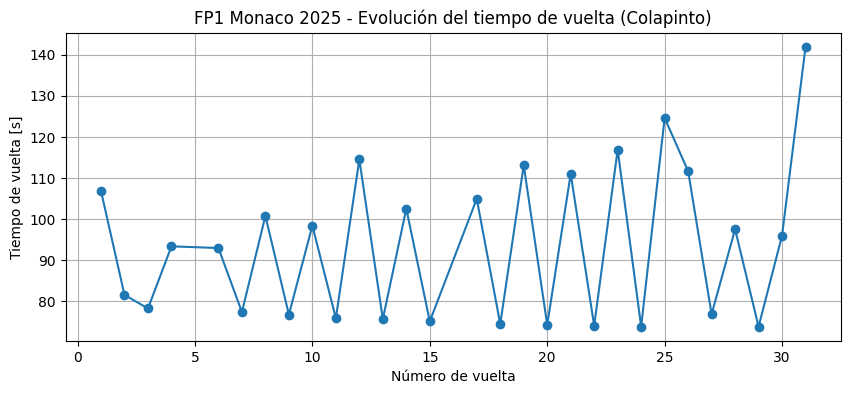

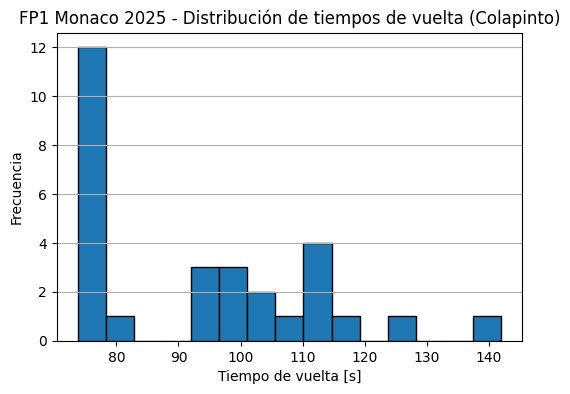

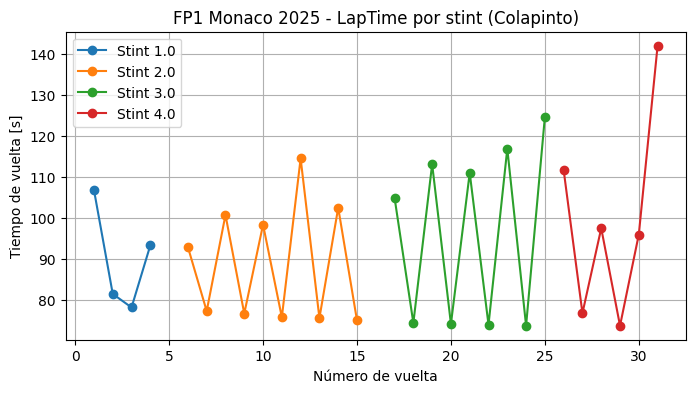

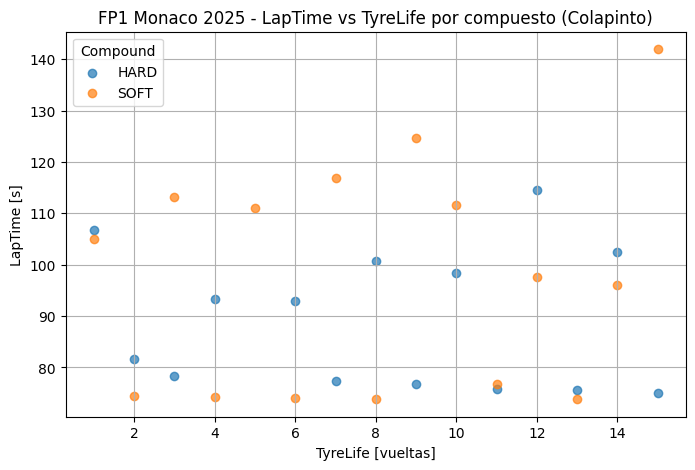

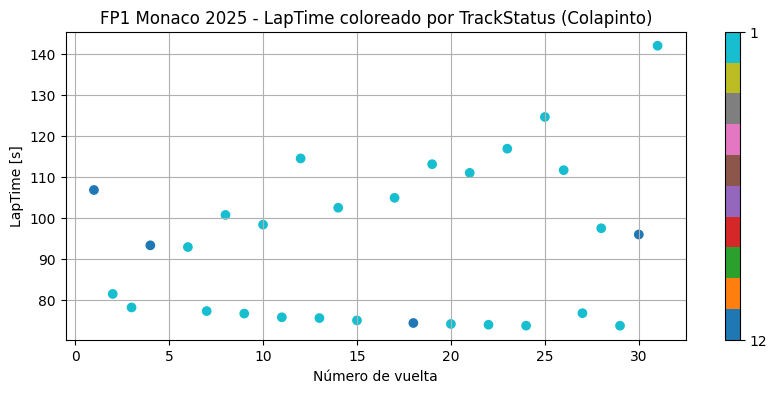

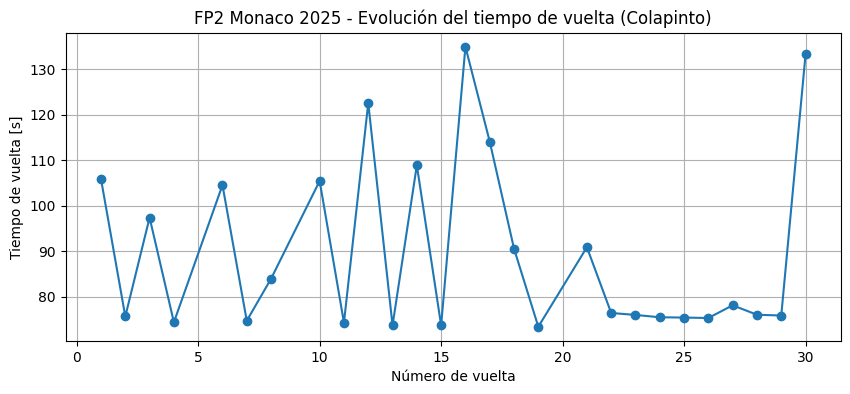

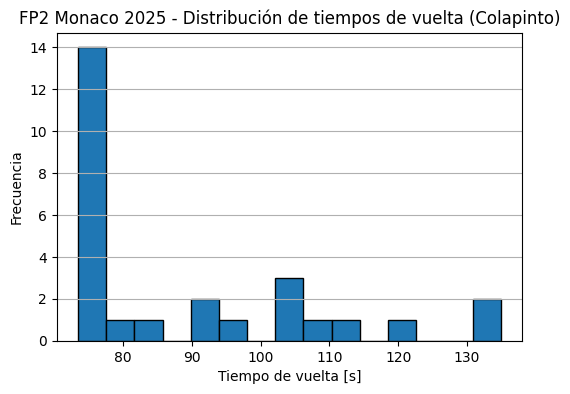

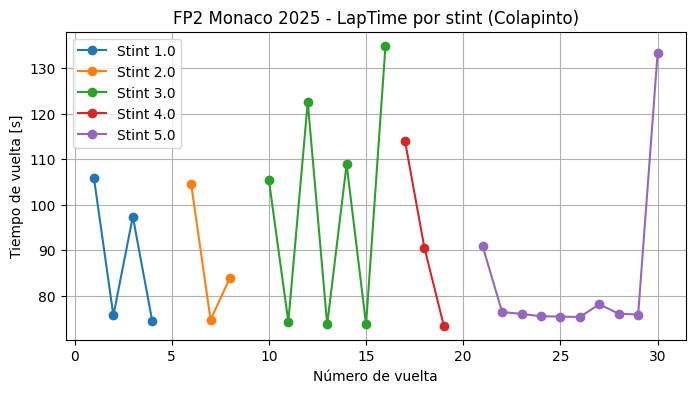

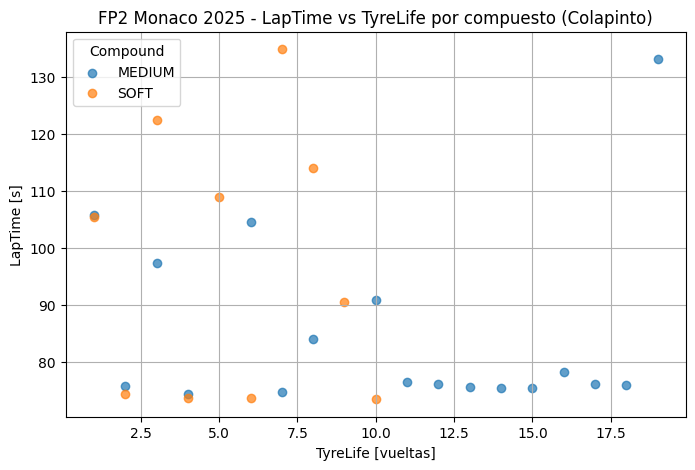

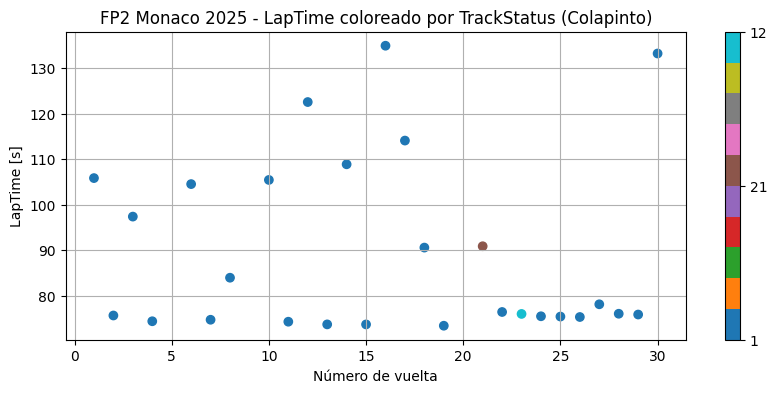

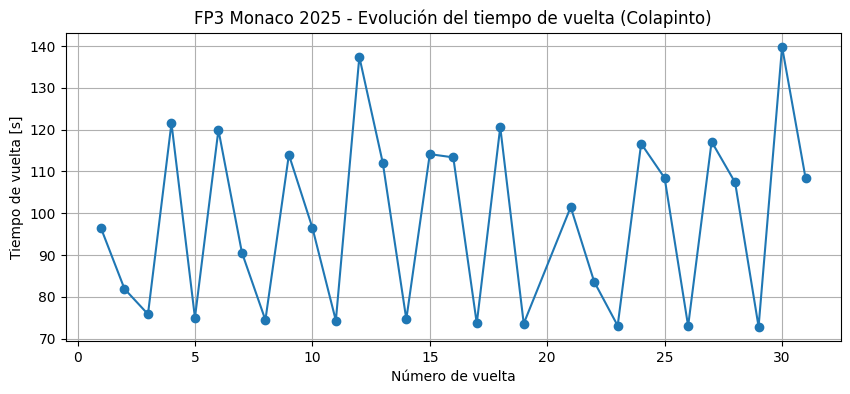

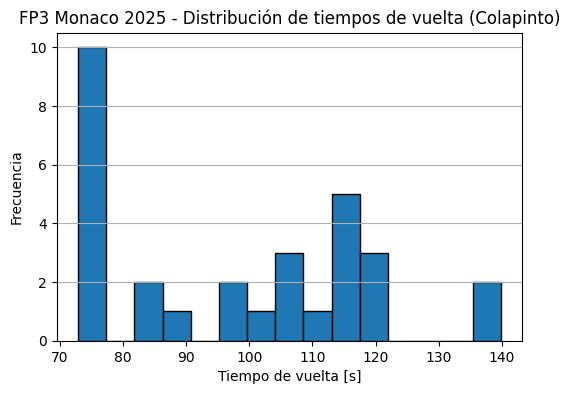

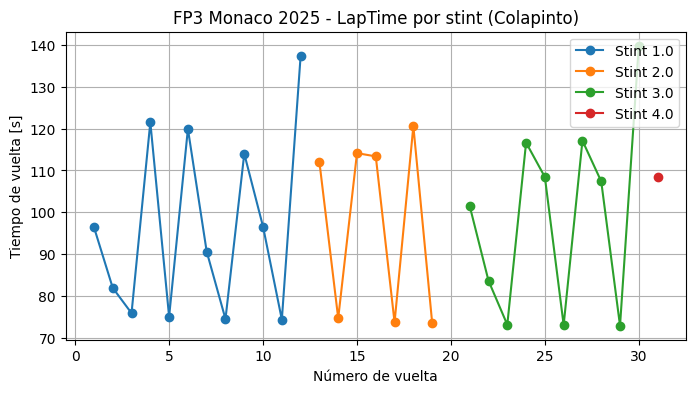

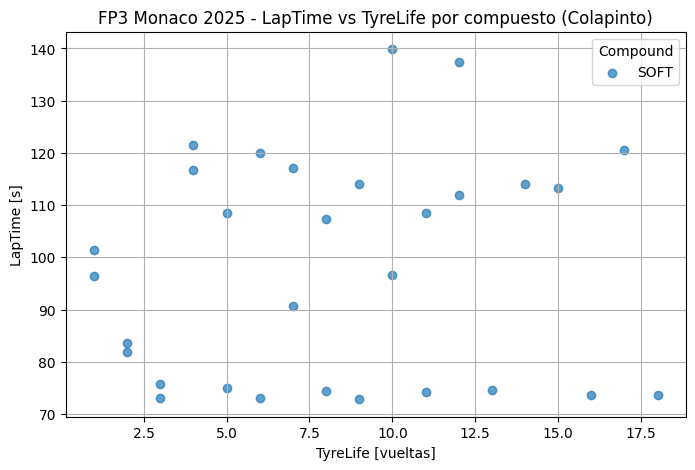

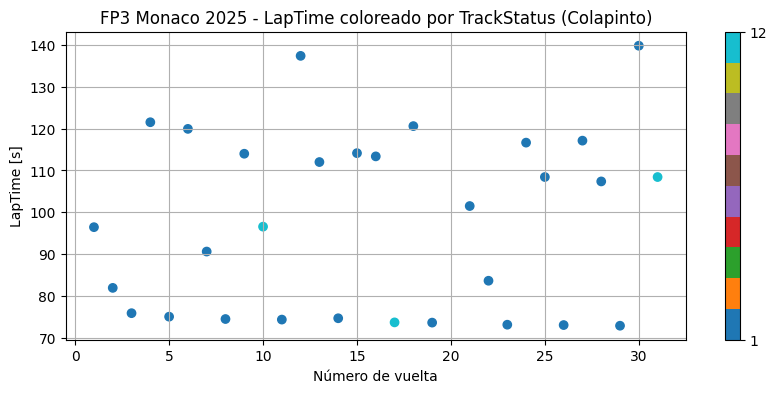

In [128]:
plots.eda_practice(col_laps_fp1, title_prefix="FP1 Monaco 2025")
plots.eda_practice(col_laps_fp2, title_prefix="FP2 Monaco 2025")
plots.eda_practice(col_laps_fp3, title_prefix="FP3 Monaco 2025")

Armado del dataset en base a las practicas 1, 2 y 3 de Colapinto en Monaco 2025

Arranco por limpiar las vueltas lentas de las practicas dejando solo las vueltas representativas

In [129]:
# Opción usando "best lap + delta" (recomendado para empezar)
col_laps_fp1_clean, cut_fp1 = pre.clean_session(col_laps_fp1, delta_from_best=5.0)
col_laps_fp2_clean, cut_fp2 = pre.clean_session(col_laps_fp2, delta_from_best=5.0)
col_laps_fp3_clean, cut_fp3 = pre.clean_session(col_laps_fp3, delta_from_best=5.0)

# Opción 2: Usando tiempo fijo puesto a mano
#col_laps_fp1_clean, cut_fp1 = pre.clean_practice_session(col_laps_fp1, laptime_max_s=90.0)
#col_laps_fp2_clean, cut_fp2 = pre.clean_practice_session(col_laps_fp2, laptime_max_s=90.0)
#col_laps_fp3_clean, cut_fp3 = pre.clean_practice_session(col_laps_fp3, laptime_max_s=90.0)


Best lap: 73.820 s, corte: 78.820 s
Vueltas antes: 29, después del filtrado: 12 (se eliminaron 17)
Best lap: 73.415 s, corte: 78.415 s
Vueltas antes: 27, después del filtrado: 15 (se eliminaron 12)
Best lap: 72.851 s, corte: 77.851 s
Vueltas antes: 30, después del filtrado: 10 (se eliminaron 20)


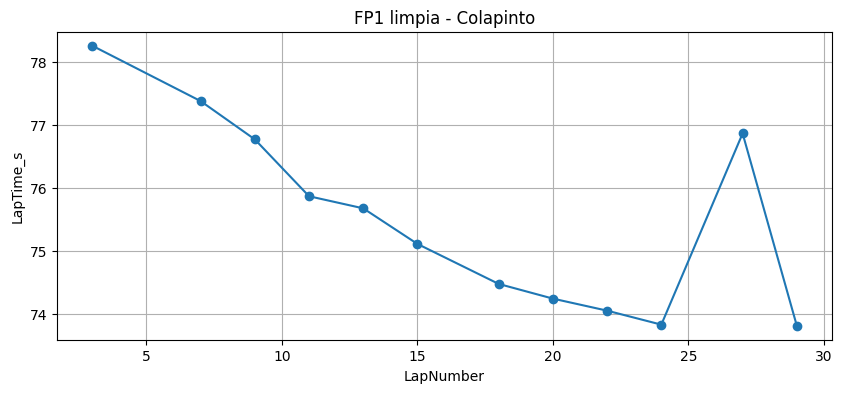

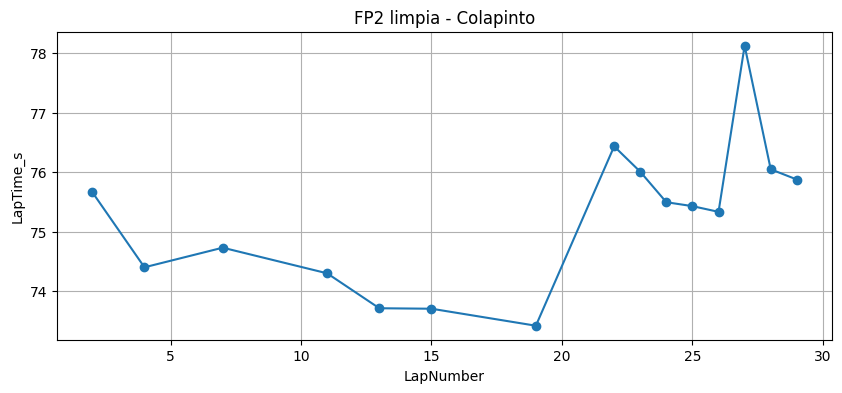

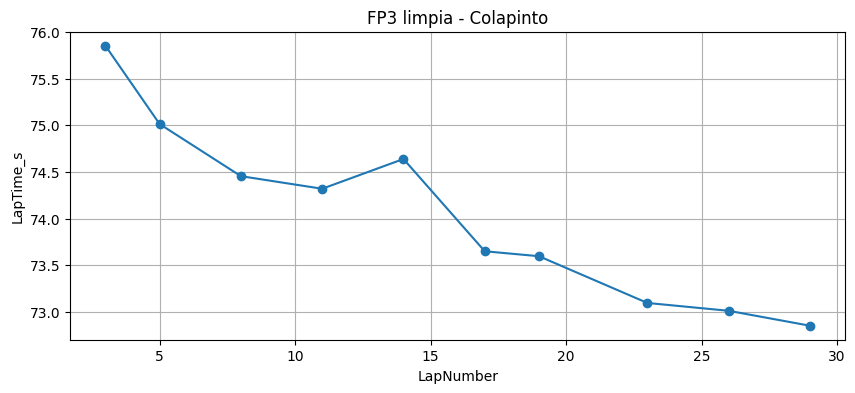

In [130]:
def quick_laptime_plot(col_laps, title=""):
    plt.figure(figsize=(10,4))
    plt.plot(col_laps["LapNumber"], col_laps["LapTime_s"], marker="o")
    plt.xlabel("LapNumber")
    plt.ylabel("LapTime_s")
    plt.title(title)
    plt.grid(True)
    plt.show()

quick_laptime_plot(col_laps_fp1_clean, "FP1 limpia - Colapinto")
quick_laptime_plot(col_laps_fp2_clean, "FP2 limpia - Colapinto")
quick_laptime_plot(col_laps_fp3_clean, "FP3 limpia - Colapinto")


Juntamos FP1 + FP2 + FP3 y guardamos CSV de train

In [131]:
col_laps_fp1_clean = col_laps_fp1_clean.copy()
col_laps_fp2_clean = col_laps_fp2_clean.copy()
col_laps_fp3_clean = col_laps_fp3_clean.copy()

col_laps_fp1_clean["Session"] = "FP1"
col_laps_fp2_clean["Session"] = "FP2"
col_laps_fp3_clean["Session"] = "FP3"

practices_clean = pd.concat(
    [col_laps_fp1_clean, col_laps_fp2_clean, col_laps_fp3_clean],
    ignore_index=True
)

print("Total de vueltas de práctica (limpias):", len(practices_clean))
practices_clean.head()


Total de vueltas de práctica (limpias): 37


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,LapTime_s,Session
0,0 days 00:21:31.817000,COL,43,0 days 00:01:18.264000,3.0,1.0,NaT,NaT,0 days 00:00:20.706000,0 days 00:00:36.862000,...,0 days 00:20:13.553000,2025-05-23 11:35:13.560,1,NaN,False,,False,True,78.264,FP1
1,0 days 00:32:59.095000,COL,43,0 days 00:01:17.385000,7.0,2.0,NaT,NaT,0 days 00:00:20.513000,0 days 00:00:36.473000,...,0 days 00:31:41.710000,2025-05-23 11:46:41.717,1,NaN,False,,False,True,77.385,FP1
2,0 days 00:35:56.644000,COL,43,0 days 00:01:16.777000,9.0,2.0,NaT,NaT,0 days 00:00:20.280000,0 days 00:00:35.999000,...,0 days 00:34:39.867000,2025-05-23 11:49:39.874,1,NaN,False,,False,True,76.777,FP1
3,0 days 00:38:50.930000,COL,43,0 days 00:01:15.875000,11.0,2.0,NaT,NaT,0 days 00:00:20.053000,0 days 00:00:35.723000,...,0 days 00:37:35.055000,2025-05-23 11:52:35.062,1,NaN,False,,False,True,75.875,FP1
4,0 days 00:42:01.132000,COL,43,0 days 00:01:15.683000,13.0,2.0,NaT,NaT,0 days 00:00:19.950000,0 days 00:00:35.552000,...,0 days 00:40:45.449000,2025-05-23 11:55:45.456,1,NaN,False,,False,True,75.683,FP1


In [132]:
output_path = "data/processed/monaco_2025_colapinto_practices_train.csv"
practices_clean.to_csv(output_path, index=False)
print("Guardado CSV de train en:", output_path)


Guardado CSV de train en: data/processed/monaco_2025_colapinto_practices_train.csv


Ahora vamos a sumar las vueltas de la carrera y sumarlas al set de las practicsas.

In [133]:
col_laps_race = get_colapinto_laps(2025, "Monaco Grand Prix", "R")
col_laps_race["Session"] = "RACE"
col_laps_race["LapTime_s"] = col_laps_race["LapTime"].dt.total_seconds()

print(f"Nº de vueltas totales en carrera: {len(col_laps_race)}")
col_laps_race.head()


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.1]


req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '16', '81', '1', '44', '6', '31', '30', '23', '55', '63', '87', '43', '5', '18', '27', '22', '12', '14', '10']


Nº de vueltas totales en carrera: 76


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,LapTime_s,Session
0,0 days 00:57:45.647000,COL,43,0 days 00:01:36.577000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:41.290000,...,0 days 00:56:08.809000,2025-05-25 13:03:09.195,126,15.0,False,,False,False,96.577,RACE
1,0 days 00:59:36.541000,COL,43,0 days 00:01:50.894000,2.0,1.0,NaT,NaT,0 days 00:00:37.987000,0 days 00:00:48.498000,...,0 days 00:57:45.647000,2025-05-25 13:04:46.033,6,15.0,False,,False,False,110.894,RACE
2,0 days 01:01:25.454000,COL,43,0 days 00:01:48.913000,3.0,1.0,NaT,NaT,0 days 00:00:31.865000,0 days 00:00:47.462000,...,0 days 00:59:36.541000,2025-05-25 13:06:36.927,6,15.0,False,,False,False,108.913,RACE
3,0 days 01:03:01.930000,COL,43,0 days 00:01:36.476000,4.0,1.0,NaT,NaT,0 days 00:00:30.548000,0 days 00:00:44.583000,...,0 days 01:01:25.454000,2025-05-25 13:08:25.840,671,15.0,False,,False,False,96.476,RACE
4,0 days 01:04:21.929000,COL,43,0 days 00:01:19.999000,5.0,1.0,NaT,NaT,0 days 00:00:20.959000,0 days 00:00:37.709000,...,0 days 01:03:01.930000,2025-05-25 13:10:02.316,1,15.0,False,,False,True,79.999,RACE


In [134]:
col_laps_race_clean, cut_race = pre.clean_session(
    col_laps_race,
    delta_from_best=15.0  # o fijalo a mano, ej. laptime_max_s=120.0
)


Best lap: 75.298 s, corte: 90.298 s
Vueltas antes: 76, después del filtrado: 70 (se eliminaron 6)


Construyo ahora el Set Final

In [135]:
# Train = prácticas + parte de carrera
race_and_practice_df = pd.concat(
    [practices_clean, col_laps_race_clean],
    ignore_index=True
)

print(f"Vueltas totales en set combinado: {len(race_and_practice_df)}")
print(race_and_practice_df["Session"].value_counts())



Vueltas totales en set combinado: 107
Session
RACE    70
FP2     15
FP1     12
FP3     10
Name: count, dtype: int64


In [136]:

# Guardar CSV único para K-Fold
output_path = "data/processed/monaco_2025_colapinto_alllaps.csv"
race_and_practice_df.to_csv(output_path, index=False)
print("CSV combinado guardado en:", output_path)


CSV combinado guardado en: data/processed/monaco_2025_colapinto_alllaps.csv
